# Generate segmentation
with optimal found parameters

author = Caroline Magg <br>
date = 28 May 2020 <br>

___________________________________
history: <br>
2020-28-05 Run first segmentation <br>
2020-01-06 Run segmentation and save images <br>
2020-02-06 Run segmentation with correct params and save images T0<br>
2020-27-07 Run segmentation with better params and save images (finer grid search) folder 1-10<br>
2020-27-07 Run segmentation with params and save images T1 folder 1-10<br>
2020-29-07 Run segmentation with params and save images T0, T1 folder 11-14 <br>
2020-29-07 Create csv with structure-wise data <br>
2020-20-08 Run segmentation again with k = 1 <br>
2020-27-08 Run segmentation with fixed bug for last slice <br>

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import pydicom
from natsort import natsorted
import scipy
import time
import logging as log
import skimage.segmentation as segmentation
import itertools

In [2]:
log.basicConfig(format='%(levelname)s:%(message)s', level=log.INFO)

### Add dependencies

In [3]:
# add KidsBrainProject main folder to paths
sys.path.append(os.path.abspath('../../'))
sys.path.append(os.path.abspath('../utils/'))

In [4]:
from PatientData import PatientData
from DicomWrapper import DicomWrapper
from Segmentation import Segmentation
from HyperparameterSearchSegmentation import HyperparameterSearchSegmentation as HyperparamSearch

In [5]:
# add path to data here
path_data = "../../Data/" 

### Contour list

In [6]:
contours_list = pd.read_csv("list_contours.csv",delimiter=',')
contours_list

,Number,RoiName,Values
0,1,Brain,"(4, 0.05, 4)"
1,2,Cerebell POST YL,"(4, 0.05, 4)"
2,3,Cingulum left,"(10, 0.1, 10)"
3,4,Cingulum right,"(10, 0.2, 10)"
4,5,Corpus callosum,"(4, 0.05, 4)"
5,6,CTV,"(10, 0.05, 10)"
6,7,CTV1,"(10, 0.05, 10)"
7,8,CTV2,"(10, 0.2, 10)"
8,9,Fornix,"(4, 0.05, 4)"
9,10,GTV,"(10, 0.2, 10)"


### Review the hyperparameter search

In [7]:
contour_of_interest = contours_list['RoiName'].values
values_of_interest = contours_list['Values'].values
print(contour_of_interest)
print(values_of_interest)
len(contour_of_interest)

['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right']
['(4, 0.05, 4)' '(4, 0.05, 4)' '(10, 0.1, 10)' '(10, 0.2, 10)'
 '(4, 0.05, 4)' '(10, 0.05, 10)' '(10, 0.05, 10)' '(10, 0.2, 10)'
 '(4, 0.05, 4)' '(10, 0.2, 10)' '(10, 0.05, 10)' '(10, 0.05, 10)'
 '(10, 0.05, 10)' '(10, 0.05, 10)' '(4, 0.05, 4)' '(10, 0.05, 10)'
 '(4, 0.05, 4)' '(10, 0.05, 10)' '(10, 0.05, 10)' '(10, 0.2, 10)'
 '(10, 0.2, 10)']


21

# Segmentation T0

In [8]:
compression_params = [cv2.IMWRITE_PNG_COMPRESSION, 0]

In [9]:
for idx in range(1,15):
    print("folder", idx)
    t = time.time()
    files = os.listdir(os.path.join(path_data, str(idx)))
    path_contour = os.path.join(path_data, str(idx), 'RS.Jacks{0}.dcm'.format(idx))
    path_preop = os.path.join(path_data, str(idx), 'CT')
    path_postop = [os.path.join(path_data, str(idx), fn) for fn in [x for x in files if 'T1' in x or 'MRT' in x]]
    
    data = PatientData(path_preop, path_postop, path_contour)
    data.read_filtered_contour(roiname=contour_of_interest, mode="exact")
    segmentor = Segmentation(data, debug=True)
    
    directory = os.path.join(path_data, str(idx), 'Segmentation')
    if not os.path.exists(directory):
        os.makedirs(directory)
    if not os.path.exists(os.path.join(directory, 'png')):
        os.makedirs(os.path.join(directory, 'png'))
    if not os.path.exists(os.path.join(directory, 'init')):
        os.makedirs(os.path.join(directory, 'init'))
    if not os.path.exists(os.path.join(directory, 't0')):
        os.makedirs(os.path.join(directory, 't0'))
        
    # dicom image -> png
    print("pngs images")
    img = data.get_pre_images()
    [cv2.imwrite(os.path.join(directory, 'png', '{0}_slice{1}.png'.format(idx,i)), img[i].astype(np.uint8), compression_params) for i in range(len(img))]

    # segmentations
    found_struct = data.get_filtered_contour_names().values
    first_index = data.contour_list_names_filtered['first'].values
    last_index = data.contour_list_names_filtered['last'].values
    # t0 segmentations
    print("t0 segmentation")
    for struct, first, last in zip(found_struct, first_index, last_index):
        tmp = contours_list[contours_list['RoiName'] == struct]['Values'].values[0]
        values = [float(x) for x in tmp.replace('(','').replace(')','').split(',')]
        cont = segmentor.active_contour(struct, postprocess=-1, first=first, last=last,
                       kernel=(int(values[0]),int(values[0])), beta=values[1], max_iterations=int(values[2])) 
        for i in range(len(cont)):
            cv2.imwrite(os.path.join(directory, 't0', '{0}_t0_{1}_slice{2}.png'.format(idx,struct,first+i)), 
                        cont[i].astype(np.uint8), 
                        compression_params)
        
    # init segmentation
    print("init segmentation")
    for ind, first, last in zip(range(len(first_index)), first_index, last_index):
        struct = found_struct[ind]
        for i in range(first, last+1):
            cv2.imwrite(os.path.join(directory, 'init', '{0}_init_{1}_slice{2}.png'.format(idx,struct,i)),
                        data.contour_list_names_filtered.iloc[ind]['mask'][i].astype(np.uint8),
                        compression_params)

INFO: Preop dicom


folder 1


INFO: Postop ../../Data/1\T1 +C 3-15-16
INFO: Postop ../../Data/1\T1 +C 3-23-16
INFO: Postop ../../Data/1\T1 +C 4-29-16
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


pngs images


INFO: Start segmentation of Brain.


t0 segmentation


C:\Users\Caroline\Documents\KidsBrainProject\KidsBrainProject\utils\Segmentation.py:134: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.
  convergence=convergence, boundary_condition=boundary_condition)
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of T

init segmentation
folder 2


INFO: Preop dicom
INFO: Postop ../../Data/2\T1 3-14-17
INFO: Postop ../../Data/2\T1 3-19-17
INFO: Postop ../../Data/2\T1POST 3-13-17
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


pngs images


INFO: Start segmentation of Brain.


t0 segmentation


INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.


init segmentation


INFO: Preop dicom


folder 3


INFO: Postop ../../Data/3\T1 C+ 2-22-17
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


pngs images


INFO: Start segmentation of Brain.


t0 segmentation


INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.


init segmentation
folder 4


INFO: Preop dicom
INFO: Postop ../../Data/4\MRT1C 02-07-17
INFO: Postop ../../Data/4\MRT1C 12-27-16
INFO: Postop ../../Data/4\MRT1C 12-31-16
INFO: Postop ../../Data/4\MRT2 02-07-17
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


pngs images


INFO: Start segmentation of Brain.


t0 segmentation


INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.


init segmentation
folder 5


INFO: Preop dicom
INFO: Postop ../../Data/5\T1 +C 02-08-17
INFO: Postop ../../Data/5\T1 +C 12-23-16
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


pngs images


INFO: Start segmentation of Brain.


t0 segmentation


INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.


init segmentation
folder 6


INFO: Preop dicom
INFO: Postop ../../Data/6\T1P 10-28-16
INFO: Postop ../../Data/6\T1P 12-1-16
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


pngs images


INFO: Start segmentation of Brain.


t0 segmentation


INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.


init segmentation


INFO: Preop dicom


folder 7


INFO: Postop ../../Data/7\T1C+ 10-21-16
INFO: Postop ../../Data/7\T1C+ 9-27-16
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


pngs images


INFO: Start segmentation of Brain.


t0 segmentation


INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.


init segmentation
folder 8


INFO: Preop dicom
INFO: Postop ../../Data/8\T1C+ 10-17-16
INFO: Postop ../../Data/8\T1C+ 8-25-16
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


pngs images
t0 segmentation


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.


init segmentation
folder 9


INFO: Preop dicom
INFO: Postop ../../Data/9\T1P 10-4-16
INFO: Postop ../../Data/9\T1P 7-26-16
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


pngs images
t0 segmentation


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.


init segmentation
folder 10


INFO: Preop dicom
INFO: Postop ../../Data/10\T1 MPR 06-22-16
INFO: Postop ../../Data/10\T1 MPR 06-27-16
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


pngs images


INFO: Start segmentation of Brain.


t0 segmentation


INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.


init segmentation
folder 11


INFO: Preop dicom
INFO: Postop ../../Data/11\T1 pre-op 2-16-17
INFO: Postop ../../Data/11\T1C PREOP 2-16-17
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


pngs images
t0 segmentation


INFO: Start segmentation of Brain.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant R.


init segmentation
folder 12


INFO: Preop dicom
INFO: Postop ../../Data/12\T1+C 10-29-16
INFO: Postop ../../Data/12\T1+C 11-2-16
INFO: Postop ../../Data/12\T1+C 11-23-16
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


pngs images


INFO: Start segmentation of Brain.


t0 segmentation


INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.


init segmentation


INFO: Preop dicom


folder 13


INFO: Postop ../../Data/13\T1 Stlth 11-27-15
INFO: Postop ../../Data/13\T1+C 12-1-15
INFO: Postop ../../Data/13\T1cBRAVO 2-24-16
INFO: Postop ../../Data/13\T1cStlth 11-27-15
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


pngs images


INFO: Start segmentation of Brain.


t0 segmentation


INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.


init segmentation
folder 14


INFO: Preop dicom
INFO: Postop ../../Data/14\MR T1+C 11-14-15
INFO: Postop ../../Data/14\MR T1+C 2-24-16
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


pngs images


INFO: Start segmentation of Brain.


t0 segmentation


INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.


init segmentation


# Segmentation T1+

In [10]:
for idx in range(1,15):
    print("folder", idx)
    t = time.time()
    files = os.listdir(os.path.join(path_data, str(idx)))
    path_contour = os.path.join(path_data, str(idx), 'RS.Jacks{0}.dcm'.format(idx))
    path_preop = os.path.join(path_data, str(idx), 'CT')
    path_postop = [os.path.join(path_data, str(idx), fn) for fn in [x for x in files if 'T1' in x or 'MRT1' in x]]
    
    data = PatientData(path_preop, path_postop, path_contour)
    data.read_filtered_contour(roiname=contour_of_interest, mode="exact")
    segmentor = Segmentation(data, debug=True)
    
    # segmentations of t0
    found_struct = data.get_filtered_contour_names().values
    first_index = data.contour_list_names_filtered['first'].values
    last_index = data.contour_list_names_filtered['last'].values
    
    directory = os.path.join(path_data, str(idx), 'Segmentation')  
    
    # t1+ segmentations and images
    for postop in range(len(data._postop_dicoms)):
        print("t{0} segmentations".format(postop+1))
        d = path_postop[postop].split('\\')[-1].split(' ')[-1]
        name = 't1 '+ d
        name02 = 'png ' + d
        if not os.path.exists(os.path.join(directory, name)):
            os.makedirs(os.path.join(directory, name))
        if not os.path.exists(os.path.join(directory, name02)):
            os.makedirs(os.path.join(directory, name02))
        # segmentation
        for struct, first, last in zip(found_struct, first_index, last_index):
            tmp = contours_list[contours_list['RoiName'] == struct]['Values'].values[0]
            values = [float(x) for x in tmp.replace('(','').replace(')','').split(',')]
            cont = segmentor.active_contour(struct, postprocess=postop, first=first, last=last,
                           kernel=(int(values[0]),int(values[0])), beta=values[1], max_iterations=int(values[2])) 
            for i in range(len(cont)):
                cv2.imwrite(os.path.join(directory, name, '{0}_t1_{3}_{1}_slice{2}.png'.format(idx,struct,first+i,d)), 
                            cont[i].astype(np.uint8), 
                            compression_params)
        # images
        img = data.get_post_images()
        [cv2.imwrite(os.path.join(directory, name02, '{0}_slice{1}.png'.format(idx,ix)), img[postop][ix].astype(np.uint8), compression_params) for ix in range(np.shape(img)[1])]

folder 1


INFO: Preop dicom
INFO: Postop ../../Data/1\T1 +C 3-15-16
INFO: Postop ../../Data/1\T1 +C 3-23-16
INFO: Postop ../../Data/1\T1 +C 4-29-16
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


t1 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.


t2 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.


t3 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.


folder 2


INFO: Preop dicom
INFO: Postop ../../Data/2\T1 3-14-17
INFO: Postop ../../Data/2\T1 3-19-17
INFO: Postop ../../Data/2\T1POST 3-13-17
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


t1 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.


t2 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.


t3 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.
INFO: Preop dicom


folder 3


INFO: Postop ../../Data/3\T1 C+ 2-22-17
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact
INFO: Start segmentation of Brain.


t1 segmentations


INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.


folder 4


INFO: Preop dicom
INFO: Postop ../../Data/4\MRT1C 02-07-17
INFO: Postop ../../Data/4\MRT1C 12-27-16
INFO: Postop ../../Data/4\MRT1C 12-31-16
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


t1 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.


t2 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.


t3 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.
INFO: Preop dicom


folder 5


INFO: Postop ../../Data/5\T1 +C 02-08-17
INFO: Postop ../../Data/5\T1 +C 12-23-16
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


t1 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.


t2 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.


folder 6


INFO: Preop dicom
INFO: Postop ../../Data/6\T1P 10-28-16
INFO: Postop ../../Data/6\T1P 12-1-16
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


t1 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.


t2 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.
INFO: Preop dicom


folder 7


INFO: Postop ../../Data/7\T1C+ 10-21-16
INFO: Postop ../../Data/7\T1C+ 9-27-16
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


t1 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.


t2 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.
INFO: Preop dicom


folder 8


INFO: Postop ../../Data/8\T1C+ 10-17-16
INFO: Postop ../../Data/8\T1C+ 8-25-16
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


t1 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.


t2 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.
INFO: Preop dicom


folder 9


INFO: Postop ../../Data/9\T1P 10-4-16
INFO: Postop ../../Data/9\T1P 7-26-16
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


t1 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.


t2 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.
INFO: Preop dicom


folder 10


INFO: Postop ../../Data/10\T1 MPR 06-22-16
INFO: Postop ../../Data/10\T1 MPR 06-27-16
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


t1 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.


t2 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Cingulum left.
INFO: Start segmentation of Cingulum right.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PapezCircle.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Start segmentation of Thalamus left.
INFO: Start segmentation of Thalamus right.
INFO: Preop dicom


folder 11


INFO: Postop ../../Data/11\T1 pre-op 2-16-17
INFO: Postop ../../Data/11\T1C PREOP 2-16-17
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


t1 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant R.


t2 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant R.
INFO: Preop dicom


folder 12


INFO: Postop ../../Data/12\T1+C 10-29-16
INFO: Postop ../../Data/12\T1+C 11-2-16
INFO: Postop ../../Data/12\T1+C 11-23-16
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


t1 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.


t2 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.


t3 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV1.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Preop dicom


folder 13


INFO: Postop ../../Data/13\T1 Stlth 11-27-15
INFO: Postop ../../Data/13\T1+C 12-1-15
INFO: Postop ../../Data/13\T1cBRAVO 2-24-16
INFO: Postop ../../Data/13\T1cStlth 11-27-15
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


t1 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.


t2 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.


t3 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.


t4 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of CTV2.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of Scalp.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.
INFO: Start segmentation of Thalamus ant L.
INFO: Start segmentation of Thalamus ant R.
INFO: Preop dicom


folder 14


INFO: Postop ../../Data/14\MR T1+C 11-14-15
INFO: Postop ../../Data/14\MR T1+C 2-24-16
INFO: Start reading contour list
INFO: Start filtering contour list for RoiNames ['Brain' 'Cerebell POST YL' 'Cingulum left' 'Cingulum right'
 'Corpus callosum' 'CTV' 'CTV1' 'CTV2' 'Fornix' 'GTV' 'Hypothalamus'
 'PapezCircle' 'PTV1' 'PTV2' 'Scalp' 'TemporalLobeLt' 'TemporalLobeRt'
 'Thalamus ant L' 'Thalamus ant R' 'Thalamus left' 'Thalamus right'] with mode exact


t1 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.


t2 segmentations


INFO: Start segmentation of Brain.
INFO: Start segmentation of Cerebell POST YL.
INFO: Start segmentation of Corpus callosum.
INFO: Start segmentation of CTV.
INFO: Start segmentation of Fornix.
INFO: Start segmentation of GTV.
INFO: Start segmentation of Hypothalamus.
INFO: Start segmentation of PTV1.
INFO: Start segmentation of PTV2.
INFO: Start segmentation of TemporalLobeLt.
INFO: Start segmentation of TemporalLobeRt.


# Create csv

In [11]:
for contour in contours_list['RoiName']:
    print(contour)
    df = pd.DataFrame(columns=['PatientID','Img','Init','Segm','Slice','RoiName'])
    for idx in range(1,15):
        directory_segm = os.path.join(path_data, str(idx),'Segmentation','t0')  
        directory_png = os.path.join(path_data, str(idx),'Segmentation','png')  
        directory_init = os.path.join(path_data, str(idx),'Segmentation','init')  
        files_segm = os.listdir(directory_segm)
        files_pngs = os.listdir(directory_png)
        files_init = os.listdir(directory_init)
        slices = [int(files_pngs[ix].replace('{0}_slice'.format(idx),'').replace('.png','')) for ix in range(len(files_pngs))]
        slices = sorted(slices)
        for ix in slices:
            fn = '{0}_slice{1}.png'.format(idx, ix)
            ln = '{0}_t0_{1}_slice{2}.png'.format(idx, contour, ix)
            ln2 = '{0}_init_{1}_slice{2}.png'.format(idx, contour, ix)
            fn_idx = files_pngs.index(fn)
            try:
                ln_idx = files_segm.index(ln)
            except:
                ln_idx = None
            try:
                init_idx = files_init.index(ln2)
            except:
                init_idx = None
            if init_idx is not None:
                row = {'PatientID': idx,
                      'Img': os.path.join(directory_png,files_pngs[fn_idx]).replace('\\','/'),
                      'Init': os.path.join(directory_init, files_init[init_idx]).replace('\\','/') if init_idx is not None else None,
                      'Segm': os.path.join(directory_segm,files_segm[ln_idx]).replace('\\','/') if ln_idx is not None else None, 
                      'Slice': ix,
                      'RoiName': contour}
                df = df.append(row, ignore_index=True)        
    df.to_csv('../../Data/data_{0}.csv'.format(contour.replace(' ','')), index=False, sep=';')    

Brain
Cerebell POST YL
Cingulum left
Cingulum right
Corpus callosum
CTV
CTV1
CTV2
Fornix
GTV
Hypothalamus
PapezCircle
PTV1
PTV2
Scalp
TemporalLobeLt
TemporalLobeRt
Thalamus ant L
Thalamus ant R
Thalamus left
Thalamus right


In [12]:
df

,PatientID,Img,Init,Segm,Slice,RoiName
0,1,../../Data/1/Segmentation/png/1_slice84.png,../../Data/1/Segmentation/init/1_init_Thalamus...,../../Data/1/Segmentation/t0/1_t0_Thalamus rig...,84,Thalamus right
1,1,../../Data/1/Segmentation/png/1_slice85.png,../../Data/1/Segmentation/init/1_init_Thalamus...,../../Data/1/Segmentation/t0/1_t0_Thalamus rig...,85,Thalamus right
2,1,../../Data/1/Segmentation/png/1_slice86.png,../../Data/1/Segmentation/init/1_init_Thalamus...,../../Data/1/Segmentation/t0/1_t0_Thalamus rig...,86,Thalamus right
3,1,../../Data/1/Segmentation/png/1_slice87.png,../../Data/1/Segmentation/init/1_init_Thalamus...,../../Data/1/Segmentation/t0/1_t0_Thalamus rig...,87,Thalamus right
4,1,../../Data/1/Segmentation/png/1_slice88.png,../../Data/1/Segmentation/init/1_init_Thalamus...,../../Data/1/Segmentation/t0/1_t0_Thalamus rig...,88,Thalamus right
...,...,...,...,...,...,...
174,10,../../Data/10/Segmentation/png/10_slice92.png,../../Data/10/Segmentation/init/10_init_Thalam...,../../Data/10/Segmentation/t0/10_t0_Thalamus r...,92,Thalamus right
175,10,../../Data/10/Segmentation/png/10_slice93.png,../../Data/10/Segmentation/init/10_init_Thalam...,../../Data/10/Segmentation/t0/10_t0_Thalamus r...,93,Thalamus right
176,10,../../Data/10/Segmentation/png/10_slice94.png,../../Data/10/Segmentation/init/10_init_Thalam...,../../Data/10/Segmentation/t0/10_t0_Thalamus r...,94,Thalamus right
177,10,../../Data/10/Segmentation/png/10_slice95.png,../../Data/10/Segmentation/init/10_init_Thalam...,../../Data/10/Segmentation/t0/10_t0_Thalamus r...,95,Thalamus right


In [23]:
df.loc[88]

PatientID                                                    6
Img               ../../Data/6/Segmentation/png/6_slice104.png
Init         ../../Data/6/Segmentation/init/6_init_Thalamus...
Segm         ../../Data/6/Segmentation/t0/6_t0_Thalamus rig...
Slice                                                      104
RoiName                                         Thalamus right
Name: 88, dtype: object

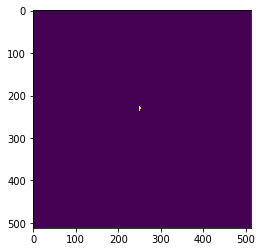

In [24]:
plt.imshow(cv2.imread(df.loc[88,'Segm'], cv2.IMREAD_GRAYSCALE))